# MMCQExtractor

Median cut extractor using ColorThief's MMCQ implementation


In [1]:
from colorthief import MMCQ
import cv2 
import numpy as np

import margo_loader
from utils.Formatting import flattish, is_visible
from ExtractorBaseClass import ExtractorBaseClass, Palette

from pathos.multiprocessing import ProcessingPool as Pool, cpu_count

In [2]:
def map_nearest(cmap, pixels, process_count):
    with Pool(process_count) as p:
        return p.map(cmap.nearest, pixels)

class MMCQExtractor(ExtractorBaseClass):
    
    def __init__(self, img, n=20, process_count=int(max(1, cpu_count() / 2))):
        super(MMCQExtractor, self).__init__(img, n=n)
        self.process_count = process_count 
        self.cmap = None
        
    def populate_palette(self):
        
        # Overrides parent method to take advantage of colorthief's MMCQ cmap, which
        # keeps track of color count internally. Prevents iterating over all pixels 
        # to count them
        
        if not self.palette.is_empty():
            return
        
        if self.cmap is None:
            self.get_color_map()
        
        for i in range(self.cmap.vboxes.size()):
            vbox = self.cmap.vboxes.peek(i)
            r, g, b = vbox["color"]
            count = vbox["vbox"].count
            self.palette.set_color_count(r, g, b, 255, count)

    def quantize(self):
        img = self.img
        n = self.n

        shape = img.shape
  
        pixels = flattish(img)#[tuple(x) for x in flattish(img) ]
        
        # Remove the alpha 0 pixels if there is an alpha channel
        if (shape[2] == 4):   
            valid_pixels = list(filter(lambda pix: pix[3] > 0, pixels))
            r, g, b, a = cv2.split(img)
        else: 
            valid_pixels=pixels
            r, g, b = cv2.split(self.image)
            a = np.uint8(np.full(b.shape, 255))
        
        # Do the median cut quantization
        cmap = MMCQ.quantize(valid_pixels, n)
        self.cmap = cmap        

        # Reconstruct the image
        with Pool(self.process_count) as p:
            cmap_pixels = p.map(cmap.map, pixels)

                
        ret = np.uint8(np.array(cmap_pixels))
        r, g, b = cv2.split(ret.reshape(img.shape[0], img.shape[1], 3))
        ret = cv2.merge((r, g, b, a))
        
        return ret

In [3]:
# :: ignore-cell ::

from PIL import Image
from utils.ImageFiles import read_img


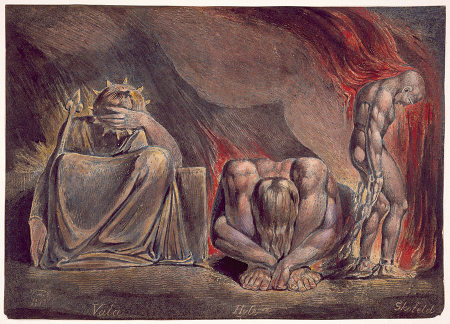

In [4]:
# :: ignore-cell ::

# Before quantization

Image.fromarray(read_img("../images/jerusalem.mpi.p22-51.100.jpg", scale=0.5))

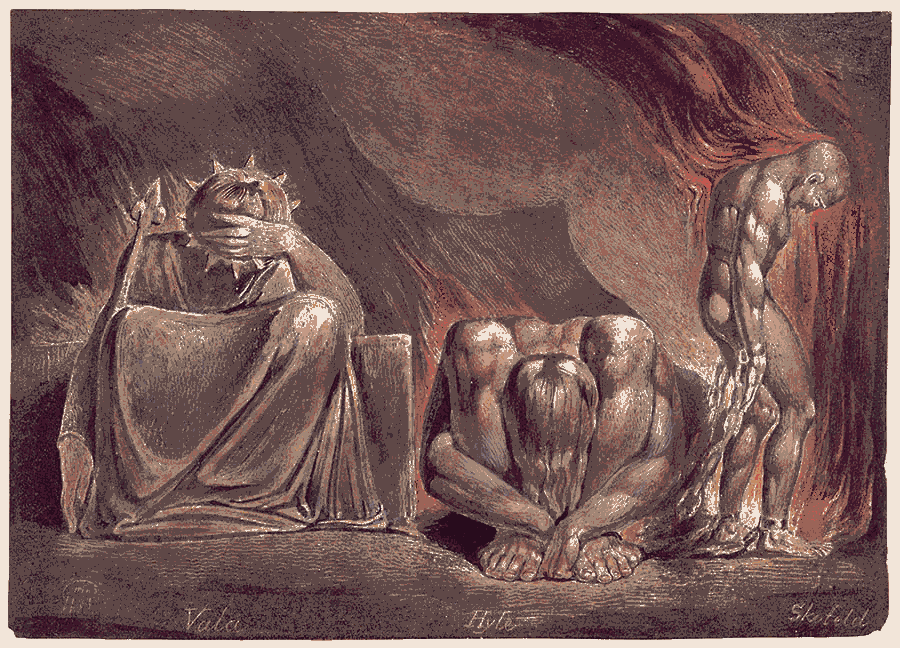

In [5]:
# :: ignore-cell ::

Image.fromarray( MMCQExtractor(read_img("../images/jerusalem.mpi.p22-51.100.jpg")).get_color_map())

In [6]:
# :: ignore-cell ::

# After quantization
# %time  Image.fromarray( MMCQExtractor(read_img("../images/jerusalem.mpi.p22-51.100.jpg")).get_color_map())

In [7]:
# %time  Image.fromarray( MMCQExtractor(read_img("../images/jerusalem.mpi.p22-51.100.jpg"), process_count=1).get_color_map())

In [8]:
# :: ignore-cell ::

# Extract a palette with a count for each color

median_extractor = MMCQExtractor(read_img("../images/jerusalem.mpi.p22-51.100.jpg", scale=1))
%time median_extractor.get_palette().to_dict()

CPU times: user 35.7 s, sys: 560 ms, total: 36.3 s
Wall time: 39.5 s


{'rgb(173,129,45)': 9,
 'rgb(165,160,173)': 18,
 'rgb(76,39,26)': 872,
 'rgb(106,90,101)': 3580,
 'rgb(178,172,160)': 175,
 'rgb(128,113,125)': 948,
 'rgb(85,41,52)': 20247,
 'rgb(194,88,80)': 1022,
 'rgb(196,139,100)': 2817,
 'rgb(128,80,75)': 35125,
 'rgb(195,153,133)': 13909,
 'rgb(64,44,52)': 44595,
 'rgb(128,105,96)': 67087,
 'rgb(62,23,42)': 28605,
 'rgb(40,12,29)': 10149,
 'rgb(155,100,88)': 33078,
 'rgb(95,72,71)': 225490,
 'rgb(242,229,217)': 40376,
 'rgb(162,134,118)': 55098}

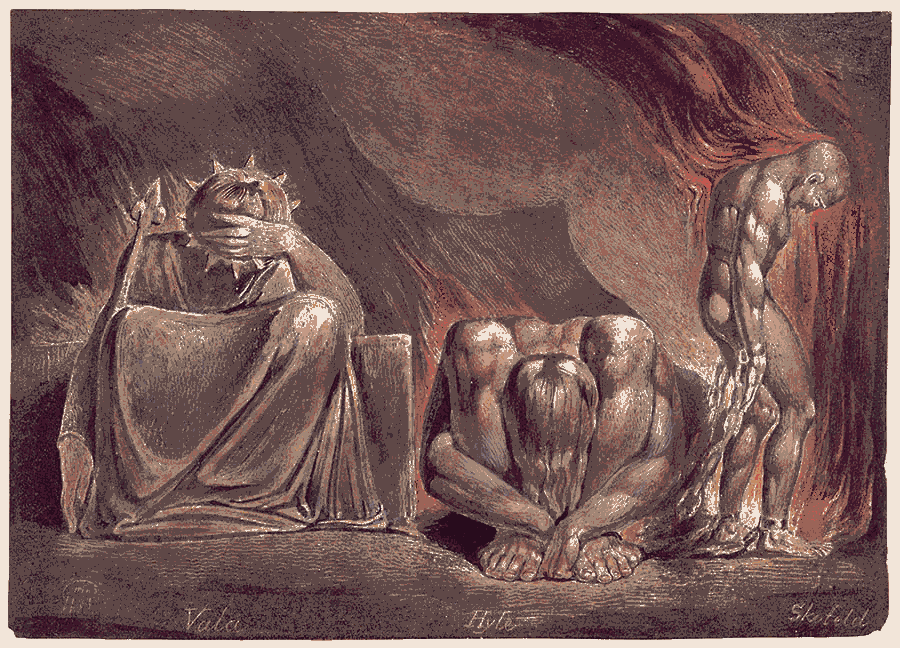

In [9]:
# :: ignore-cell ::

# Get the color map, which is the quantized image. 

Image.fromarray(median_extractor.get_color_map())

In [10]:
# :: ignore-cell ::
p_dict =  median_extractor.palette.to_dict()
tot = 0
for k in p_dict.keys():
    tot += p_dict[k]
print(tot)

583200


In [11]:
# :: ignore-cell ::

tot = 0

for i in range(median_extractor.cmap.vboxes.size()):
    count = median_extractor.cmap.vboxes.peek(i)["vbox"].count
    print(median_extractor.cmap.vboxes.peek(i)["color"], count)
    tot += count
    
print(tot)

(173, 129, 45) 9
(165, 160, 173) 18
(76, 39, 26) 872
(106, 90, 101) 3580
(178, 172, 160) 175
(128, 113, 125) 948
(85, 41, 52) 20247
(194, 88, 80) 1022
(196, 139, 100) 2817
(128, 80, 75) 35125
(195, 153, 133) 13909
(64, 44, 52) 44595
(128, 105, 96) 67087
(62, 23, 42) 28605
(40, 12, 29) 10149
(155, 100, 88) 33078
(95, 72, 71) 225490
(242, 229, 217) 40376
(162, 134, 118) 55098
583200


In [12]:
from IPython.core.display import display, HTML
from functools import reduce
def visualize_palette(p, proportional=False):
    count = len(p.keys())
    total_px = reduce(lambda a,b : a+b,[p[k] for k in p.keys()])
    ret = "<div style='height: 30px'>"
    
    for rgb in p.keys():
        width = f"{100 / count}%"
        if (proportional):
            width = f"{100 * p[rgb] / total_px}%"
        ret += f"<div style='float:left; background-color:{rgb}; width:{width}; height: 100%' class='swatch' ></div>"
    ret += "<div style='clear:both'></div></div>"
    
    display(HTML(ret))


In [13]:
# :: ignore-cell ::
visualize_palette(median_extractor.get_palette().to_dict())

In [14]:
# :: ignore-cell ::
visualize_palette(median_extractor.get_palette().to_dict(), proportional=True)